# Set-Up

In [662]:
from __future__ import division, print_function, unicode_literals
from matplotlib import pyplot as plt
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import time
import tflearn
from tflearn.data_utils import shuffle, to_categorical
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.estimator import regression
from tflearn.data_preprocessing import ImagePreprocessing
from tflearn.data_augmentation import ImageAugmentation
from tflearn.metrics import Accuracy

RANDOM_SEED = 9999

# ignore warnings
from sklearn.exceptions import DataConversionWarning
import warnings

warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings('ignore', category=DataConversionWarning)
warnings.simplefilter("ignore", category=PendingDeprecationWarning)
warnings.simplefilter('ignore', category=DeprecationWarning)

# To make output stable across runs
def reset_graph(seed= RANDOM_SEED):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# Data Preparation

In [685]:
# set cats and dogs dimensions
height = 64
width = 64 

# read in cats and dogs grayscale 64x64
cats_1000_64_64_1 = np.load('cats_dogs_64-128/cats_1000_64_64_1.npy')
dogs_1000_64_64_1 = np.load('cats_dogs_64-128/dogs_1000_64_64_1.npy')
cats_1000_64_64_3 = np.load('cats_dogs_64-128/cats_1000_64_64_3.npy')
dogs_1000_64_64_3 = np.load('cats_dogs_64-128/dogs_1000_64_64_3.npy')

# Data Exploration

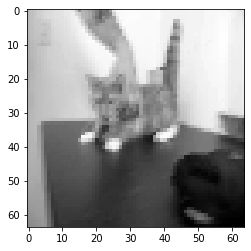

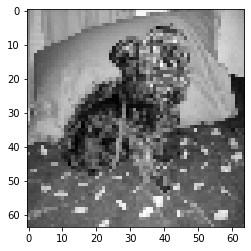

In [686]:
def show_grayscale_image(image):
    plt.imshow(image, cmap='gray')
    plt.axis('on')
    plt.show()
    
# examine first cat and first dog grayscale images
show_grayscale_image(cats_1000_64_64_1[0,:,:,0])
show_grayscale_image(dogs_1000_64_64_1[0,:,:,0])

In [762]:
# create a empty dataframe for results
results = []
results = pd.DataFrame(results)

# empty list for training and testing accuracy, and runtime
training_accuracy =[]
test_accuracy =[]
model_time =[]


# set up column names
col = ['Color', '# of Conv Layers', 'Time (in sec)', 
       'Training Accuracy', 'Test Accuracy']

reset_graph()

# Deep Neural Networks

<b>Data Preparation</b>

In [763]:
# Stack the numpy arrays for the inputs
X_cat_dog = np.concatenate((cats_1000_64_64_1, dogs_1000_64_64_1), axis = 0) 
X_cat_dog = X_cat_dog.reshape(-1,width*height) # note coversion to 4096 inputs

# Scikit Learn for min-max scaling of the data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(np.array([0., 255.]).reshape(-1,1))
X_cat_dog_min_max = scaler.transform(X_cat_dog)

# Define the labels to be used 1000 cats = 0 1000 dogs = 1
y_cat_dog = np.concatenate((np.zeros((1000), dtype = np.int32), 
                      np.ones((1000), dtype = np.int32)), axis = 0)

# Scikit Learn for random splitting of the data  
from sklearn.model_selection import train_test_split

# Random splitting of data  
X_train, X_test, y_train, y_test = \
    train_test_split(X_cat_dog_min_max, y_cat_dog, test_size=0.20, 
                     random_state = RANDOM_SEED)

X_train, X_val, y_train, y_val = \
    train_test_split(X_train, y_train, test_size=0.20, 
                     random_state=RANDOM_SEED)

<b>Model A</b>

2 hidden layers, 64x64 Grayscale images

In [764]:
# 300 and 100 nodes for layers 1 and 2
n_hidden1 = 300
n_hidden2 = 100
n_inputs = height * width
n_epochs = 50
batch_size = 100
# binary classification for cats and dogs
n_outputs = 2 

reset_graph()

# set placeholders
X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

def neuron_layer(X, n_neurons, name, activation=None):
    with tf.name_scope(name):
        n_inputs = int(X.get_shape()[1])
        stddev = 2 / np.sqrt(n_inputs)
        init = tf.truncated_normal((n_inputs, n_neurons), stddev=stddev)
        W = tf.Variable(init, name="kernel")
        b = tf.Variable(tf.zeros([n_neurons]), name="bias")
        Z = tf.matmul(X, W) + b
        if activation is not None:
            return activation(Z)
        else:
            return Z

with tf.name_scope("dnn"):
    hidden1 = neuron_layer(X, n_hidden1, name="hidden1",
                           activation=tf.nn.relu)
    hidden2 = neuron_layer(hidden1, n_hidden2, name="hidden2",
                           activation=tf.nn.relu)
    logits = neuron_layer(hidden2, n_outputs, name="outputs")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,
                                                              logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)
    
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))    

init = tf.global_variables_initializer()
saver = tf.train.Saver() 

with tf.Session() as sess:
    init.run()
    
    #initialize time
    start_time = time.clock()
    
    for epoch in range(n_epochs):
        for iteration in range(y_train.shape[0] // batch_size):
            X_batch = X_train[iteration*batch_size:(iteration + 1)*batch_size,:]
            y_batch = y_train[iteration*batch_size:(iteration + 1)*batch_size]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_val = accuracy.eval(feed_dict={X: X_val, y: y_val})
        acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
        print(epoch, "Train accuracy:", acc_train, "Validation accuracy:", 
              acc_val, "Test accuracy:", acc_test)
    
    a_train = acc_train
    a_val = acc_val
    a_test = acc_test
    training_accuracy.append(a_train)
    val_accuracy.append(a_val)
    test_accuracy.append(a_test)
    
     #End Time
    end_time = time.clock()

    a_time = end_time - start_time
    
    #append the results to the list
    model_time.append(a_time)

0 Train accuracy: 0.58 Validation accuracy: 0.528125 Test accuracy: 0.535
1 Train accuracy: 0.64 Validation accuracy: 0.546875 Test accuracy: 0.5425
2 Train accuracy: 0.69 Validation accuracy: 0.553125 Test accuracy: 0.535
3 Train accuracy: 0.68 Validation accuracy: 0.559375 Test accuracy: 0.545
4 Train accuracy: 0.69 Validation accuracy: 0.55625 Test accuracy: 0.555
5 Train accuracy: 0.73 Validation accuracy: 0.56875 Test accuracy: 0.56
6 Train accuracy: 0.73 Validation accuracy: 0.58125 Test accuracy: 0.5625
7 Train accuracy: 0.71 Validation accuracy: 0.584375 Test accuracy: 0.5525
8 Train accuracy: 0.71 Validation accuracy: 0.5875 Test accuracy: 0.55
9 Train accuracy: 0.74 Validation accuracy: 0.575 Test accuracy: 0.57
10 Train accuracy: 0.74 Validation accuracy: 0.578125 Test accuracy: 0.5575
11 Train accuracy: 0.75 Validation accuracy: 0.571875 Test accuracy: 0.555
12 Train accuracy: 0.76 Validation accuracy: 0.575 Test accuracy: 0.5575
13 Train accuracy: 0.78 Validation accuracy:

In [765]:
print("Baseline Results:------------------------")
print("Train Accuracy: {}\nValidation Accuracy: {}\nTest Accuracy: {}".format(a_train, a_val, a_test))

Baseline Results:------------------------
Train Accuracy: 0.8700000047683716
Validation Accuracy: 0.590624988079071
Test Accuracy: 0.5649999976158142


<b>Model B</b>

2 hidden layers, 64x64 RGB images

<b>Data Preparation for RGB Images</b>

In [766]:
# Stack the numpy arrays for the inputs
X_cat_dog1 = np.concatenate((cats_1000_64_64_3, dogs_1000_64_64_3), axis = 0) 
X_cat_dog1 = X_cat_dog.reshape(-1,width*height) # note coversion to 4096 inputs

# Scikit Learn for min-max scaling of the data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(np.array([0., 255.]).reshape(-1,1))
X_cat_dog_min_max1 = scaler.transform(X_cat_dog1)

# Define the labels to be used 1000 cats = 0 1000 dogs = 1
y_cat_dog1 = np.concatenate((np.zeros((1000), dtype = np.int32), 
                      np.ones((1000), dtype = np.int32)), axis = 0)

# Scikit Learn for random splitting of the data  
from sklearn.model_selection import train_test_split

# Random splitting of data  
X_train, X_test, y_train, y_test = \
    train_test_split(X_cat_dog_min_max1, y_cat_dog1, test_size=0.20, 
                     random_state = RANDOM_SEED)

X_train, X_val, y_train, y_val = \
    train_test_split(X_train, y_train, test_size=0.20, 
                     random_state=RANDOM_SEED)

In [768]:
# 300 and 100 nodes for layers 1 and 2
n_hidden1 = 300
n_hidden2 = 100
n_inputs = height * width
n_epochs = 50
batch_size = 100
# binary classification for cats and dogs
n_outputs = 2 

reset_graph()

# set placeholders
X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

def neuron_layer(X, n_neurons, name, activation=None):
    with tf.name_scope(name):
        n_inputs = int(X.get_shape()[1])
        stddev = 2 / np.sqrt(n_inputs)
        init = tf.truncated_normal((n_inputs, n_neurons), stddev=stddev)
        W = tf.Variable(init, name="kernel")
        b = tf.Variable(tf.zeros([n_neurons]), name="bias")
        Z = tf.matmul(X, W) + b
        if activation is not None:
            return activation(Z)
        else:
            return Z

with tf.name_scope("dnn"):
    hidden1 = neuron_layer(X, n_hidden1, name="hidden1",
                           activation=tf.nn.relu)
    hidden2 = neuron_layer(hidden1, n_hidden2, name="hidden2",
                           activation=tf.nn.relu)
    logits = neuron_layer(hidden2, n_outputs, name="outputs")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,
                                                              logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)
    
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))    

init = tf.global_variables_initializer()
saver = tf.train.Saver() 

with tf.Session() as sess:
    init.run()
    
    #initialize time
    start_time = time.clock()
    
    for epoch in range(n_epochs):
        for iteration in range(y_train.shape[0] // batch_size):
            X_batch = X_train[iteration*batch_size:(iteration + 1)*batch_size,:]
            y_batch = y_train[iteration*batch_size:(iteration + 1)*batch_size]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_val = accuracy.eval(feed_dict={X: X_val, y: y_val})
        acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
        print(epoch, "Train accuracy:", acc_train, "Validation accuracy:", 
              acc_val, "Test accuracy:", acc_test)
    
    b_train = acc_train
    b_val = acc_val
    b_test = acc_test
    training_accuracy.append(b_train)
    val_accuracy.append(b_val)
    test_accuracy.append(b_test)
    
     #End Time
    end_time = time.clock()

    b_time = end_time - start_time
    
    #append the results to the list
    model_time.append(b_time)

0 Train accuracy: 0.58 Validation accuracy: 0.528125 Test accuracy: 0.535
1 Train accuracy: 0.64 Validation accuracy: 0.546875 Test accuracy: 0.5425
2 Train accuracy: 0.69 Validation accuracy: 0.553125 Test accuracy: 0.535
3 Train accuracy: 0.68 Validation accuracy: 0.559375 Test accuracy: 0.545
4 Train accuracy: 0.69 Validation accuracy: 0.55625 Test accuracy: 0.555
5 Train accuracy: 0.73 Validation accuracy: 0.56875 Test accuracy: 0.56
6 Train accuracy: 0.73 Validation accuracy: 0.58125 Test accuracy: 0.5625
7 Train accuracy: 0.71 Validation accuracy: 0.584375 Test accuracy: 0.5525
8 Train accuracy: 0.71 Validation accuracy: 0.5875 Test accuracy: 0.55
9 Train accuracy: 0.74 Validation accuracy: 0.575 Test accuracy: 0.57
10 Train accuracy: 0.74 Validation accuracy: 0.578125 Test accuracy: 0.5575
11 Train accuracy: 0.75 Validation accuracy: 0.571875 Test accuracy: 0.555
12 Train accuracy: 0.76 Validation accuracy: 0.575 Test accuracy: 0.5575
13 Train accuracy: 0.78 Validation accuracy:

In [769]:
print("Baseline Results:------------------------")
print("Train Accuracy: {}\nValidation Accuracy: {}\nTest Accuracy: {}".format(b_train, b_val, b_test))

Baseline Results:------------------------
Train Accuracy: 0.8700000047683716
Validation Accuracy: 0.590624988079071
Test Accuracy: 0.5649999976158142


# Convolutional Neural Networks

<b> Data Preparation for CNN</b>

Adapted from: http://www.subsubroutine.com/sub-subroutine/2016/9/30/cats-and-dogs-and-convolutional-neural-networks

In [674]:
# Stack the numpy arrays for the inputs
X_cat_dog_a = np.concatenate((cats_1000_64_64_3, dogs_1000_64_64_3), axis = 0) 
#X_cat_dog_a = X_cat_dog_a.reshape(-1,width*height) # note coversion to 4096 inputs
#X_cat_dog_a = X_cat_dog_a.reshape(-1,width*height)
# Define the labels to be used 1000 cats = 0 1000 dogs = 1
y_cat_dog_a = np.concatenate((np.zeros((1000), dtype = np.int32), 
                      np.ones((1000), dtype = np.int32)), axis = 0)

# Scikit Learn for random splitting of the data  
from sklearn.model_selection import train_test_split
# Random splitting of data  
X_train_a, X_test_a, y_train_a, y_test_a = \
    train_test_split(X_cat_dog_a, y_cat_dog_a, test_size=0.20, 
                     random_state = RANDOM_SEED)

# encode the Ys
y_train_a = to_categorical(y_train_a, 2)
y_test_a = to_categorical(y_test_a, 2)

In [675]:
reset_graph()

#set height & width
height = 64
width = 64
channels = 3

In [676]:
# Real-time data preprocessing
img_prep = ImagePreprocessing()
img_prep.add_featurewise_zero_center()
img_prep.add_featurewise_stdnorm()

# Real-time data augmentation
img_aug = ImageAugmentation()
img_aug.add_random_flip_leftright()
img_aug.add_random_rotation(max_angle=25.)

<b>Model C</b>

RGB, 3 Convolutional Layers, 2 Pooling Layers, 1 Fully Connected Layer

In [679]:
# Convolutional network building
network = input_data(shape=[None, 64, 64, 3],
                     data_preprocessing=img_prep,
                     data_augmentation=img_aug)

# 1: Convolution layer with 32 filters, each 3x3x3
conv_1 = conv_2d(network, 32, 3, activation='relu', name='conv_1')

# 2: Max pooling layer
network = max_pool_2d(conv_1, 2)

# 3: Convolution layer with 64 filters
conv_2 = conv_2d(network, 64, 3, activation='relu', name='conv_2')

# 4: Convolution layer with 64 filters
conv_3 = conv_2d(conv_2, 64, 3, activation='relu', name='conv_3')

# 5: Max pooling layer
network = max_pool_2d(conv_3, 2)

# 6: Fully-connected 512 node layer
network = fully_connected(network, 512, activation='relu')

# 7: Dropout layer to combat overfitting
network = dropout(network, 0.5)

# 8: Fully-connected layer with two outputs
network = fully_connected(network, 2, activation='softmax')


acc = Accuracy(name="Accuracy")
network = regression(network, optimizer='adam',
                     loss='categorical_crossentropy',
                     learning_rate=0.00005, metric=acc)
# Wrap the network in a model object
model = tflearn.DNN(network, checkpoint_path='model_cat_dog_6.tflearn', 
                    max_checkpoints = 1, tensorboard_verbose = 2, 
                    tensorboard_dir='tmp/tflearn_logs/')

In [680]:
%time

tf.reset_default_graph()

#initialize time
start_time = time.clock()

# Train the model
model.fit(X_train_a, y_train_a, n_epoch=100, 
          validation_set=(X_test_a, y_test_a),show_metric=True, 
          batch_size=256, run_id='model_cat_dog_6')

#End Time
end_time = time.clock()

cnn1_time = end_time - start_time
model.save('model_cat_dog_6_final.tflearn')

Training Step: 699  | total loss: 0.42564 | time: 6.564s
| Adam | epoch: 100 | loss: 0.42564 - Accuracy: 0.9411 -- iter: 1536/1600
Training Step: 700  | total loss: 0.38555 | time: 8.894s
| Adam | epoch: 100 | loss: 0.38555 - Accuracy: 0.9466 | val_loss: 0.90288 - val_acc: 0.6850 -- iter: 1600/1600
--


W0809 12:53:32.150146 24512 meta_graph.py:449] Issue encountered when serializing data_preprocessing.
Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'ImagePreprocessing' object has no attribute 'name'
W0809 12:53:32.155133 24512 meta_graph.py:449] Issue encountered when serializing data_augmentation.
Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'ImageAugmentation' object has no attribute 'name'
W0809 12:53:32.157128 24512 meta_graph.py:449] Issue encountered when serializing summary_tags.
Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'dict' object has no attribute 'name'


In [738]:
#append the results to the list
model_time.append(cnn1_time)

In [770]:
c_train = 0.9466
training_accuracy.append(c_train)

c_test = 0.6860
test_accuracy.append(c_test)

<b> Model D</b>

Grayscale, 2 Convolutional Layers, 1 Pooling Layers, 2 Fully Connected Layer

In [744]:
# Stack the numpy arrays for the inputs
X_cat_dog_b = np.concatenate((cats_1000_64_64_1, dogs_1000_64_64_1), axis = 0) 
#X_cat_dog_a = X_cat_dog_a.reshape(-1,width*height) # note coversion to 4096 inputs
#X_cat_dog_a = X_cat_dog_a.reshape(-1,width*height)
# Define the labels to be used 1000 cats = 0 1000 dogs = 1
y_cat_dog_b = np.concatenate((np.zeros((1000), dtype = np.int32), 
                      np.ones((1000), dtype = np.int32)), axis = 0)

# Scikit Learn for random splitting of the data  
from sklearn.model_selection import train_test_split
# Random splitting of data  
X_train_b, X_test_b, y_train_b, y_test_b = \
    train_test_split(X_cat_dog_b, y_cat_dog_b, test_size=0.20, 
                     random_state = RANDOM_SEED)

# encode the Ys
y_train_b = to_categorical(y_train_b, 2)
y_test_b = to_categorical(y_test_b, 2)

In [745]:
reset_graph()

#set height & width
height = 64
width = 64
channels = 1

In [746]:
# Real-time data preprocessing
img_prep = ImagePreprocessing()
img_prep.add_featurewise_zero_center()
img_prep.add_featurewise_stdnorm()

# Real-time data augmentation
img_aug = ImageAugmentation()
img_aug.add_random_flip_leftright()
img_aug.add_random_rotation(max_angle=25.)

In [747]:
# Convolutional network building
network = input_data(shape=[None, 64, 64, 1],
                     data_preprocessing=img_prep,
                     data_augmentation=img_aug)

# 1: Convolution layer with 32 filters, each 3x3x3
conv_1 = conv_2d(network, 32, 3, activation='relu', name='conv_1')

# 2: Max pooling layer
network = max_pool_2d(conv_1, 2)

# 3: Convolution layer with 64 filters
conv_2 = conv_2d(network, 64, 3, activation='relu', name='conv_2')

# 4: Convolution layer with 64 filters
conv_3 = conv_2d(conv_2, 64, 3, activation='relu', name='conv_3')

# 5: Max pooling layer
network = max_pool_2d(conv_3, 2)

# 6: Fully-connected 512 node layer
network = fully_connected(network, 512, activation='relu')

# 7: Dropout layer to combat overfitting
network = dropout(network, 0.5)

# 8: Fully-connected layer with two outputs
network = fully_connected(network, 2, activation='softmax')


acc = Accuracy(name="Accuracy")
network = regression(network, optimizer='adam',
                     loss='categorical_crossentropy',
                     learning_rate=0.00005, metric=acc)
# Wrap the network in a model object
model = tflearn.DNN(network, checkpoint_path='model_cat_dog_6.tflearn', 
                    max_checkpoints = 1, tensorboard_verbose = 2, 
                    tensorboard_dir='tmp/tflearn_logs/')

In [748]:
%time

tf.reset_default_graph()

#initialize time
start_time = time.clock()

# Train the model
model.fit(X_train_b, y_train_b, n_epoch=100, 
          validation_set=(X_test_b, y_test_b),show_metric=True, 
          batch_size=256, run_id='model_cat_dog_6')

#End Time
end_time = time.clock()

cnn2_time = end_time - start_time
model.save('model_cat_dog_6_final.tflearn')

Training Step: 699  | total loss: 0.44853 | time: 6.523s
| Adam | epoch: 100 | loss: 0.44853 - Accuracy: 0.9319 -- iter: 1536/1600
Training Step: 700  | total loss: 0.40511 | time: 8.844s
| Adam | epoch: 100 | loss: 0.40511 - Accuracy: 0.9387 | val_loss: 1.01746 - val_acc: 0.6525 -- iter: 1600/1600
--


W0809 16:42:02.441892 24512 meta_graph.py:449] Issue encountered when serializing data_preprocessing.
Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'ImagePreprocessing' object has no attribute 'name'
W0809 16:42:02.447885 24512 meta_graph.py:449] Issue encountered when serializing data_augmentation.
Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'ImageAugmentation' object has no attribute 'name'
W0809 16:42:02.448882 24512 meta_graph.py:449] Issue encountered when serializing summary_tags.
Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'dict' object has no attribute 'name'


In [751]:
#append the results to the list
model_time.append(cnn2_time)

In [771]:
d_train = 0.9387
training_accuracy.append(d_train)

d_test = 0.6525
test_accuracy.append(d_test)

# Final Results

In [752]:
model_time = pd.DataFrame(model_time, columns=['Processing Time (seconds)'],
                         index = ['Model A', 'Model B', 'Model C', 'Model D'])
model_time

,Processing Time (seconds)
Model A,5.050180
Model B,4.909892
Model C,903.163326
Model D,935.644844


In [778]:
# Average Accuracy
training_accuracy_df = pd.DataFrame(training_accuracy, columns=['Train Accuracy'],
                         index = ['Model r4A','Model A', 'Model B', 'Model C', 'Model D'])
training_accuracy_df.drop('Model r4A')

,Train Accuracy
Model A,0.8700
Model B,0.8700
Model C,0.9466
Model D,0.9387


In [779]:
# Average Accuracy
test_accuracy_df = pd.DataFrame(test_accuracy, columns=['Test Accuracy'],
                         index = ['Model r4A','Model A', 'Model B', 'Model C', 'Model D'])
test_accuracy_df.drop('Model r4A')

,Test Accuracy
Model A,0.5650
Model B,0.5650
Model C,0.6860
Model D,0.6525


In [785]:
results = training_accuracy_df
results['Test Accuracy'] = test_accuracy_df['Test Accuracy']
results['Processing Time (seconds)'] = model_time['Processing Time (seconds)']
results = results.drop('Model r4A')
results

,Train Accuracy,Test Accuracy,Processing Time (seconds)
Model A,0.8700,0.5650,5.050180
Model B,0.8700,0.5650,4.909892
Model C,0.9466,0.6860,903.163326
Model D,0.9387,0.6525,935.644844


Recommendation: Use Model C as it yield higher train and test accuracy compared to the other models, even at the expensive of a longer computational runtime.